### Monte Carlo code by Carmen Garcia Landeira (ID:33173370)

In [74]:
import numpy as np
from matplotlib import pyplot as plt


In [297]:
#function to see whether a new solution is accepted or rejected
def metropolis(f_x, f_x_star, t, minimisation=False):
    delta = (-1 if minimisation else 1)*(f_x_star - f_x)
    if delta > 0:
        return True
    return np.random.random() < np.exp(delta/t)

#function to alter a solution given
def peturb_TSP(sol):
    idxs = range(len(sol))
    first, second = np.random.choice(idxs, 2, replace=False)
    new_sol = sol.copy()
    new_sol[first], new_sol[second] = new_sol[second], new_sol[first]
    return new_sol

#calculates cost of a solution
def quality_TSP_Gen(M):
    def quality_TSP(sol):
        cost = 0
        for i in range(len(sol)):
            cost += M[sol[i-1], sol[i]]
        return cost
    return quality_TSP

#performs simmulated annealing iterations
def SA(f, peturb, sol, per_temp, t0, alpha, minimisation=False, tol=1e-3, verbose=False):
    T = t0
    if verbose: print("initial guess: {0}, quality: {1}".format(sol, f(sol)))
    while T > tol:
        for _ in range(per_temp):
            sol_new = peturb(sol)
            if metropolis(f(sol), f(sol_new), T, minimisation=minimisation):
                sol = sol_new.copy()
        if verbose: print("Best Guess at T={0}: {1}, quality: {2}".format(T, sol, f(sol)))
        T = alpha*T
    if verbose: print("Best Guess: {0}, quality: {1}".format(sol, f(sol)))
    return sol, f(sol)

### Running base model for comparison

In [300]:
#declaring the distances between the cities
T = np.array([
    [0, 2053, 1155, 3017, 1385, 1456],
    [2053, 0, 1080, 3415, 939, 2876],
    [1155, 1080, 0, 3940, 285, 856],
    [3017, 3415, 3940, 0, 3975, 1984],
    [1385, 939, 285, 3975, 0, 3278],
    [1456, 2876, 856, 1984, 3278, 0]
    ])

sol_0 = [0, 1, 2, 3, 4, 5]  # Starting state
f = quality_TSP_Gen(T)
per_temp = 5
t0 = 1
tol=1e-5
verbose=True
alpha=0.99
path, quality = SA(f=f, peturb=peturb_TSP, sol=sol_0, per_temp=per_temp, 
                   t0=t0, alpha=alpha, tol=tol, minimisation=True,
                   verbose=True)
print(path, quality)


initial guess: [0, 1, 2, 3, 4, 5], quality: 15782
Best Guess at T=1: [0, 1, 2, 4, 3, 5], quality: 10833
Best Guess at T=0.99: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9801: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9702989999999999: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.96059601: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9509900498999999: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9414801494009999: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9320653479069899: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.92274469442792: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9135172474836407: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.9043820750088043: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.8953382542587163: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.8863848717161291: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.8775210229989678: [0, 1, 4, 2, 5, 3], quality: 9134
Best Guess at T=0.8687

### Running with added human error

In [301]:
#function to see whether a new solution is accepted or rejected with introduced human error
def metropolis(f_x, f_x_star, t, minimisation=False):
    delta = (-1 if minimisation else 1)*(f_x_star - f_x)
    if delta > 0 and np.random.random() < 0.5:
        return True
    return np.random.random() < 0.5

[1, 3, 2, 5, 4, 0] 14927


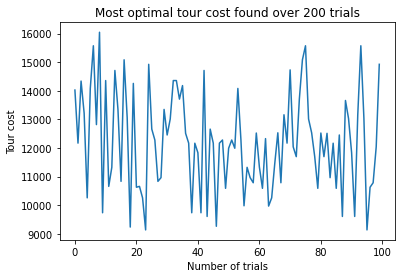

In [302]:
trials = np.arange(100) #number of trials
outputs = []

#running the simmulated annealing proccess with the ergodic chain for 100 trials.
for _ in trials:
    path, quality = SA(f=f, peturb=peturb_TSP, sol=sol_0, per_temp=per_temp, 
                   t0=t0, alpha=alpha, tol=tol, minimisation=True,
                   verbose=False)
    outputs.append(quality)

plt.plot(trials, outputs)
plt.title("Most optimal tour cost found over 200 trials")
plt.xlabel("Number of trials")
plt.ylabel("Tour cost")
print(path, quality)

### Running with added human error and weather states (transition matrix)

In [303]:
#calculates cost of a solution with weather state multipliers applied
def cal_distance(M):
    def calculate(sol, state, multipliers):
        dist = 0
        for i in range(len(sol)):
            dist += M[sol[i-1], sol[i]] * multipliers[state][i]
        return dist
    return calculate

#performs simmulated annealing iterations with weather states implemented
def SA2(f, peturb, sol, per_temp, t0, alpha, transition_matrix, state, multipliers, minimisation=False, tol=1e-3, verbose=True):
    states = []
    states_trials = 0
    T = t0
    while T > tol:
        for _ in range(per_temp):
            sol_new = peturb(sol)
            if metropolis(f(sol, state, multipliers), f(sol_new, state, multipliers), T, minimisation=minimisation):
                sol = sol_new.copy()
            states.append(state)
            states_trials += 1
            state = np.random.choice([0,1,2], p =transition_matrix[state])
        if verbose: print("Best Guess at T={0}: {1}, quality: {2}".format(T, sol, f(sol, state, multipliers)))
        T = alpha*T
    if verbose: print("Best Guess: {0}, quality: {1}".format(sol, f(sol, state, multipliers)))    
    return sol, f(sol, state, multipliers), states, states_trials


In [304]:
#declaring absorbtion transition matrix
absorption_matrix = np.array([[1, 0, 0],
                              [0.15, 0.5, 0.35],
                              [0.15, 0.35, 0.5]])

#declaring weather multiplyiers
weather_mult = np.array([[1, 1, 1, 1, 1, 1],
                          [1, 1.5, 1.5, 1.5, 1, 1.5],
                          [2, 1, 1, 2, 2, 1]])

#defining transition matrix in canonical form
ergodic_matrix = np.array([[0.90, 0.05, 0.05],
                            [0.15, 0.5, 0.35],
                            [0.15, 0.35, 0.5]])

Text(0, 0.5, 'Tour cost')

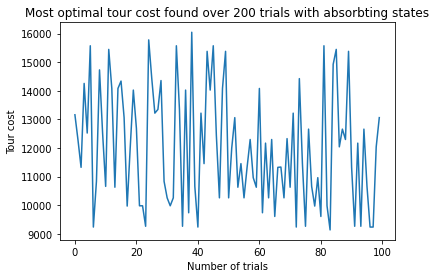

In [305]:
f = cal_distance(T) #using the function that takes into account weather states

trials = np.arange(100) #number of trials
outputs = []

for _ in trials: #running the simmulated annealing proccess with the ergodic chain for 100 trials.
    path, quality, states, states_trials = SA2(f=f, peturb=peturb_TSP, sol=sol_0, per_temp=per_temp, 
                   t0=t0, alpha=alpha, transition_matrix=absorption_matrix, state= 1, multipliers=weather_mult, tol=tol, minimisation=True, verbose=False)
    outputs.append(quality)

plt.plot(trials, outputs)
plt.title("Most optimal tour cost found over 200 trials with absorbting states")
plt.xlabel("Number of trials")
plt.ylabel("Tour cost")

### Running with added human error and weather states (ergodic matrix)

Text(0, 0.5, 'Tour cost')

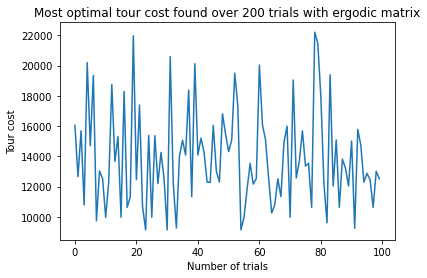

In [307]:
trials = np.arange(100) #number of trials
outputs = []

for _ in trials:#running the simmulated annealing proccess with the ergodic chain for 100 trials.
    path, quality, states, states_trials = SA2(f=f, peturb=peturb_TSP, sol=sol_0, per_temp=per_temp, 
                   t0=t0, alpha=alpha, transition_matrix=ergodic_matrix, state= 1, multipliers=weather_mult, tol=tol, minimisation=True, verbose=False)
    outputs.append(quality)

plt.plot(trials, outputs)
plt.title("Most optimal tour cost found over 200 trials with ergodic matrix")
plt.xlabel("Number of trials")
plt.ylabel("Tour cost")
